# **필요 라이브러리 불러오기**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision

# **MNIST데이터 다운로드**

In [ ]:
transform = transforms.Compose([
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(  0.5), std=( 0.5))
])
dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
img, label = next(iter(data_loader))

# **MNIST데이터 확인**



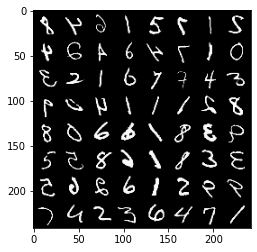

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(img))

# **Discriminator(판별자)모델 생성**
Sigmiod함수를 사용해 0~1값 가지도록 설정

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

# **Generator(생성자)모델 생성**
Tanh함수를 사용해 -1~1의 값을 가지도록 설정

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)


# **GPU사용을 위해 cuda사용**

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

#    **손실함수 정의**
# **두 모델은 Adam optimizer를 이용해서 학습**

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

# **generator모델 학습 손실값 구하는 함수**

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

# **discriminator모델 학습 손실값 구하는 함수**

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

# **epochs = 50 으로 학습**

---

*   처음에는 노이즈 이미지만 생성
*   지속적으로 학습하며 점점 원본 데이터와 비슷한 이미지데이터 생성
*   loss값 뒤죽박죽




Starting epoch 0...
g_loss: 1.7743515968322754, d_loss: 0.22923406958580017


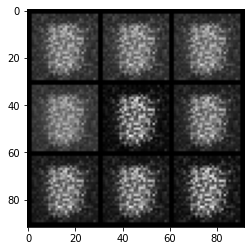

Starting epoch 1...
g_loss: 2.0864109992980957, d_loss: 0.1954711675643921


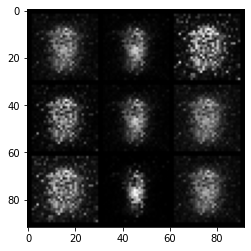

Starting epoch 2...
g_loss: 2.0424365997314453, d_loss: 0.21902024745941162


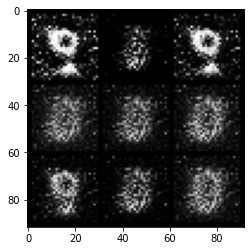

Starting epoch 3...
g_loss: 4.221460819244385, d_loss: 0.1449463665485382


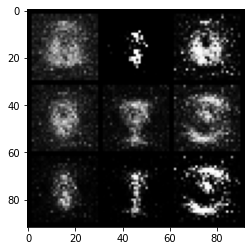

Starting epoch 4...
g_loss: 4.690094947814941, d_loss: 0.19290173053741455


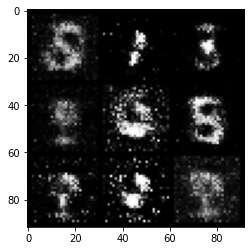

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

# **생성된 fake이미지 출력**

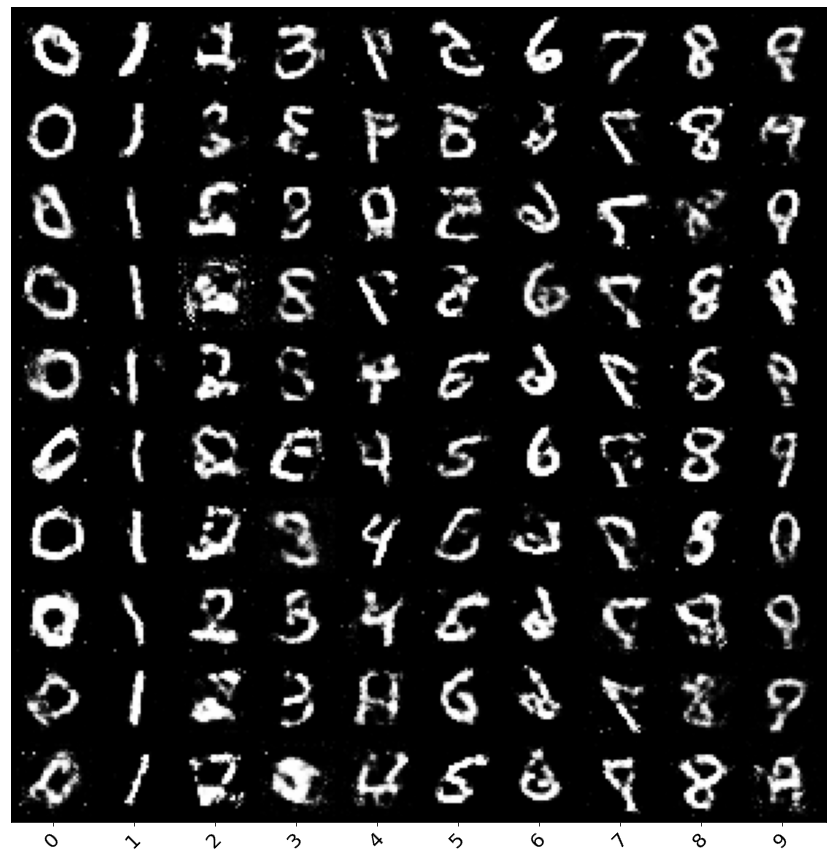

In [ ]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], rotation=45, fontsize=20)